## Notes
#### This pipeline uses the provided helper functions as well as the extrapolation method discussed in [this](https://www.youtube.com/watch?v=hnXkCiM2RSg&feature=youtu.be&t=1787) Q&A video

## How To Use
#### Running the whole notebook will run through the pipeline breakdown as well as the test procedures for images and videos. It outputs test images and videos for both the segmented and extrapolated versions in the following directories:

- Original Test Images: \test_images
- Original Test Videos: \test_videos

- Segmented Images: \test_images\output\segment
- Extrapolated Images: \test_images\output\extrapolated
- Segmented Videos: \test_videos\output\segment
- Extrapolated Videos: \test_videos\output\extrapolated

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Define Test Locations

In [2]:
imageLocation = 'test_images'
videoLocation = 'test_videos'
imageSegmentOutputLocation = 'test_images\output\segment'
videoSegmentOutputLocation = 'test_videos\output\segment'
imageExtrapolatedOutputLocation = 'test_images\output\extrapolated'
videoExtrapolatedOutputLocation = 'test_videos\output\extrapolated'

test_images = {}
test_videos = {}
test_images_segments_outputs = {}
test_videos_segments_outputs = {}
test_images_extrapolated_outputs = {}
test_videos_extrapolated_outputs = {}

## Get Test Images and Outputs

In [3]:
images = os.listdir(imageLocation)
for image in images:
    if os.path.isfile(imageLocation + '\\' + image):
        test_images[image] = imageLocation + '\\' + image
        test_images_segments_outputs[image] = imageSegmentOutputLocation + '\\' + image
        test_images_extrapolated_outputs[image] = imageExtrapolatedOutputLocation + '\\' + image

## Get Test Videos and Outputs

In [4]:
videos = os.listdir(videoLocation)
for video in videos:
    if os.path.isfile(videoLocation + '\\' + video):
        test_videos[video] = videoLocation + '\\' + video
        test_videos_segments_outputs[video] = videoSegmentOutputLocation + '\\' + video
        test_videos_extrapolated_outputs[video] = videoExtrapolatedOutputLocation + '\\' + video

## Define a global variable for line output

In [5]:
extrapolate = False

## Grayscale Helper

In [6]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## Canny Helper

In [7]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

## Gaussian Blur Helper

In [8]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

## Region of Interest Helper

In [9]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Draw Lines Helper

In [10]:
def draw_lines(img, lines, vertices, color=[255, 0, 0], thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if extrapolate:
        (centers, slopes) = centers_slopes(lines, 10)
        (center, slope) = center_slope(centers, slopes)
        (XR, XL) = X_Y(center, slope)
        (L1, L2, R1, R2) = endpoints(XR, XL, vertices)

        cv2.line(img, L1, L2, color, thickness)
        cv2.line(img, R1, R2, color, thickness)
    else:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

## Find all centers and slopes

In [11]:
def centers_slopes(lines, slope_cap):
    rcenter = []
    lcenter = []
    rslope = []
    lslope = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2 - y1) / (x2 - x1)
            c = ((x2 + x1) / 2, (y2 + y1)/2)
            
            if (m >= 0) and (m <= slope_cap):
                rcenter.append(c)
                rslope.append(m)
                
            elif(m <= 0) and (m >= -slope_cap):
                lcenter.append(c)
                lslope.append(m)
                
    return (rcenter, lcenter), (rslope, lslope)

## Find single center and slope using average

In [12]:
def center_slope(centers, slopes):
    rcenter = np.divide(np.sum(centers[0], axis=0), len(centers[0]))
    lcenter = np.divide(np.sum(centers[1], axis=0), len(centers[1]))
    rslope = np.sum(slopes[0]) / len(slopes[0])
    lslope = np.sum(slopes[1]) / len(slopes[1])
    
    return (rcenter, lcenter), (rslope, lslope)

## Find X and Y parameters

In [13]:
# X = (y - y')/m + x'
# Y = m(x - x') + y'
def X_Y(centers, slopes):
    # x' and y'
    rcenter = centers[0]
    lcenter = centers[1]
    # m
    rslope = slopes[0]
    lslope = slopes[1]
    
    # X = (y - y')/m + x'
    XL = (-lcenter[1], lslope, lcenter[0])
    XR = (-rcenter[1], rslope, rcenter[0])
    # Y = m(x - x') + y'
    #YL = (lslope, -lcenter[0], lcenter[1])
    #YR = (rslope, -rcenter[0], rcenter[1])
    
    return (XR, XL)

## Find vertices of left and right lines

In [14]:
def endpoints(XR, XL, vertices):
    
    bottomLeft = vertices[0]
    topLeft = vertices[1]
    topRight = vertices[2]
    bottomRight = vertices[3]
    
    L_y1 = bottomLeft[1]
    L_x1 = ((L_y1 + XL[0])/XL[1]) + XL[2]
    L_y2 = topLeft[1]
    L_x2 = ((L_y2 + XL[0])/XL[1]) + XL[2]
    
    R_y1 = topLeft[1]
    R_x1 = ((R_y1 + XR[0])/XR[1]) + XR[2]
    R_y2 = bottomLeft[1]
    R_x2 = ((R_y2 + XR[0])/XR[1]) + XR[2]
    
    return(int(L_x1), int(L_y1)), (int(L_x2), int(L_y2)), (int(R_x1), int(R_y1)), (int(R_x2), int(R_y2))
    

## Hough Lines Helper

In [15]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, vertices):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, vertices)
    
    return line_img

## Weighted Image Helper

In [16]:
# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Pipeline Breakdown

### Get image

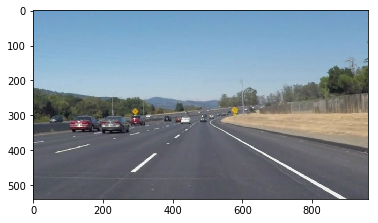

In [17]:
image = mpimg.imread(test_images['solidWhiteCurve.jpg'])
plt.imshow(image)
plt.show()

### Get Image Properties

In [18]:
imshape = image.shape
width = imshape[1]
height = imshape[0]

verticalScalingFactor = 0.6
horizontalScalingFactor = 0.08
    
bottomLeft = (width * horizontalScalingFactor, height)
topLeft = (width*0.45, height * verticalScalingFactor)
topRight = (width*0.55, height * verticalScalingFactor)
bottomRight = (width - width * horizontalScalingFactor, height)

print("Image is {}x{}".format(width, height))

Image is 960x540


### Convert to grayscale

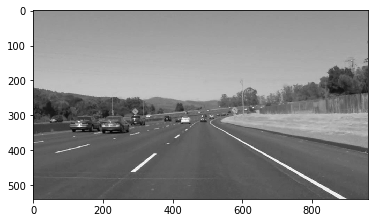

In [19]:
imgray = grayscale(image)
plt.imshow(imgray, cmap='gray')
plt.show()

### Use Gaussian smoothing

In [20]:
kernel_size = 5
imgraysmooth = gaussian_blur(imgray, kernel_size)

### Use Canny edge detection

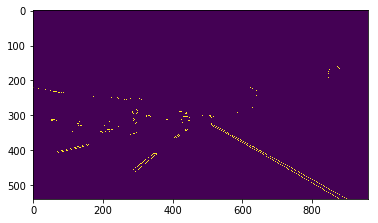

In [21]:
low_threshold = 200
high_threshold = 250
imcanny = canny(imgraysmooth, low_threshold, high_threshold)
plt.imshow(imcanny)
plt.show()

### Apply a region of interest

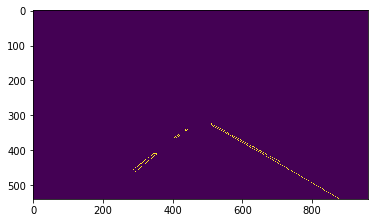

In [22]:
vertices = np.array([[bottomLeft, topLeft, topRight, bottomRight]], dtype=np.int32)
    
working_region = region_of_interest(imcanny, vertices)
    
plt.imshow(working_region)
plt.show()

### Apply Hough transform - Showing non extrapolated version of image

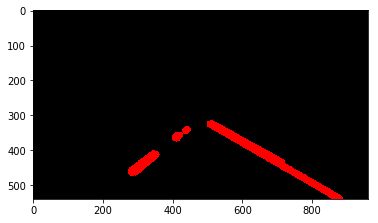

In [23]:
rho = 1
theta = np.pi/180
threshold = 5
minLineLength = 5
maxLineGap = 1

expanded_vertices = [bottomLeft, topLeft, topRight, bottomRight]

hough_img = hough_lines(working_region, rho, theta, threshold, minLineLength, maxLineGap, expanded_vertices)

plt.imshow(hough_img)
plt.show()

### Overlay lines on original image

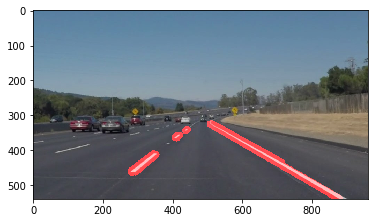

In [24]:
a = 0.8
b = 1
c = 0
    
result = weighted_img(hough_img, image, a, b, c)

plt.imshow(result)
plt.show()

## Pipeline

In [25]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    imshape = image.shape
    width = imshape[1]
    height = imshape[0]
    
    # Greyscale the image
    grey_img = grayscale(image)
    
    # Use Gaussian smoothing
    kernel_size = 5
    smooth_gray = gaussian_blur(grey_img, kernel_size)
    
    # Use Canny edge detection
    low_threshold = 150
    high_threshold = 200
    canny_img = canny(smooth_gray, low_threshold, high_threshold)
    
    # Apply a region of interest
    
    verticalScalingFactor = 0.6
    horizontalScalingFactor = 0.08
    
    bottomLeft = (width * horizontalScalingFactor, height)
    topLeft = (width*0.45, height * verticalScalingFactor)
    topRight = (width*0.55, height * verticalScalingFactor)
    bottomRight = (width - width * horizontalScalingFactor, height)
    
    expanded_vertices = [bottomLeft, topLeft, topRight, bottomRight]
    
    vertices = np.array([[bottomLeft, topLeft, topRight, bottomRight]], dtype=np.int32)
    
    working_region = region_of_interest(canny_img, vertices)
    
    # Apply Hough transform
    rho = 1
    theta = np.pi/180
    threshold = 5
    minLineLength = 5
    maxLineGap = 1
    
    hough_img = hough_lines(working_region, rho, theta, threshold, minLineLength, maxLineGap, expanded_vertices)
    
    # Draw lines on original image
    a = 0.8
    b = 1
    c = 0
    
    result = weighted_img(hough_img, image, a, b, c)
    
    return result

## Segmented Image Tests

solidWhiteCurve.jpg


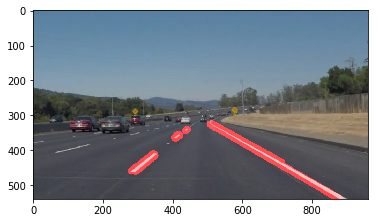

solidWhiteRight.jpg


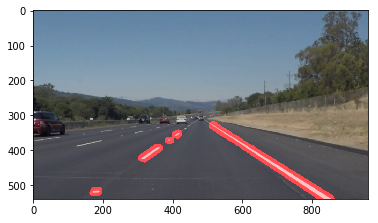

solidYellowCurve.jpg


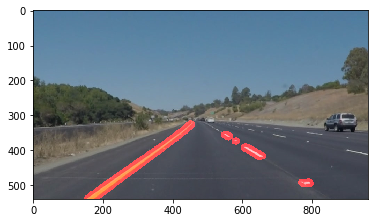

solidYellowCurve2.jpg


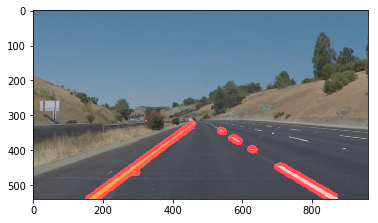

solidYellowLeft.jpg


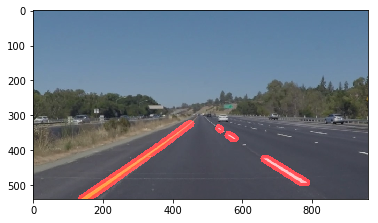

whiteCarLaneSwitch.jpg


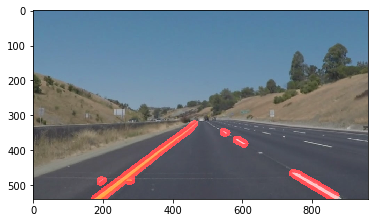

In [26]:
Extrapolate = False

for name, path in test_images.items():
    try:
        print(name)
        image = mpimg.imread(path)
        result = process_image(image)
        cv2.imwrite(test_images_segments_outputs[name], cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.imshow(result)
        plt.show()
    except Exception as e:
        print(e)

## Segmented Video Tests

In [27]:
for name, path in test_videos.items():
    try:
        print(path)
        ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
        ## To do so add .subclip(start_second,end_second) to the end of the line below
        ## Where start_second and end_second are integer values representing the start and end of the subclip
        ## You may also uncomment the following line for a subclip of the first 5 seconds
        ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
        vid_clip = VideoFileClip(path)
        result = vid_clip.fl_image(process_image) #NOTE: this function expects color images!!
        %time result.write_videofile(test_videos_segments_outputs[name], audio=False)
        vid_clip.reader.close()
        vid_clip.audio.reader.close_proc()
    except:
        print("Error")

test_videos\challenge.mp4
[MoviePy] >>>> Building video test_videos\output\segment\challenge.mp4
[MoviePy] Writing video test_videos\output\segment\challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:10<00:00, 25.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos\output\segment\challenge.mp4 

Wall time: 11.9 s
test_videos\solidWhiteRight.mp4
[MoviePy] >>>> Building video test_videos\output\segment\solidWhiteRight.mp4
[MoviePy] Writing video test_videos\output\segment\solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:04<00:00, 44.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos\output\segment\solidWhiteRight.mp4 

Wall time: 5.61 s
test_videos\solidYellowLeft.mp4
[MoviePy] >>>> Building video test_videos\output\segment\solidYellowLeft.mp4
[MoviePy] Writing video test_videos\output\segment\solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:15<00:00, 43.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos\output\segment\solidYellowLeft.mp4 

Wall time: 16.1 s


In [28]:
print("challenge.mp4")
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos\\output\\segment\\challenge.mp4"))

challenge.mp4


In [29]:
print("solidWhiteRight.mp4")
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos\\output\\segment\\solidWhiteRight.mp4"))

solidWhiteRight.mp4


In [30]:
print("solidYellowLeft.mp4")
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos\\output\\segment\\solidYellowLeft.mp4"))

solidYellowLeft.mp4


## Extrapolated Image Tests

solidWhiteCurve.jpg


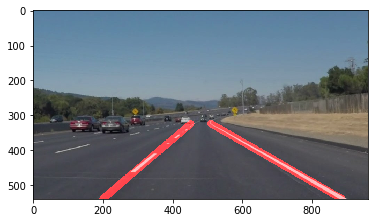

solidWhiteRight.jpg


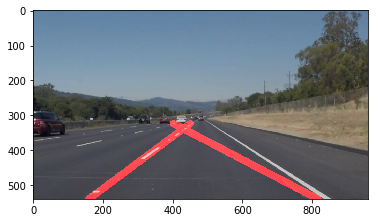

solidYellowCurve.jpg


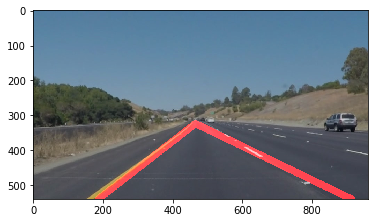

solidYellowCurve2.jpg


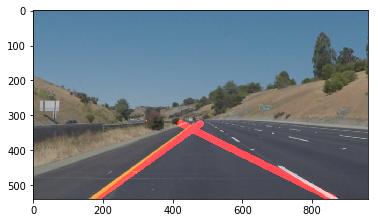

solidYellowLeft.jpg


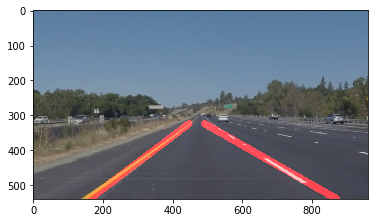

whiteCarLaneSwitch.jpg


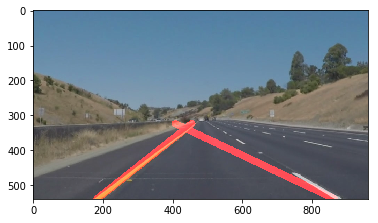

In [31]:
extrapolate = True

for name, path in test_images.items():
    try:
        print(name)
        image = mpimg.imread(path)
        result = process_image(image)
        cv2.imwrite(test_images_extrapolated_outputs[name], cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.imshow(result)
        plt.show()
    except Exception as e:
        print(e)

## Extrapolated Video Tests

In [32]:
for name, path in test_videos.items():
    try:
        print(path)
        ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
        ## To do so add .subclip(start_second,end_second) to the end of the line below
        ## Where start_second and end_second are integer values representing the start and end of the subclip
        ## You may also uncomment the following line for a subclip of the first 5 seconds
        ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
        vid_clip = VideoFileClip(path)
        result = vid_clip.fl_image(process_image) #NOTE: this function expects color images!!
        %time result.write_videofile(test_videos_extrapolated_outputs[name], audio=False)
        vid_clip.reader.close()
        vid_clip.audio.reader.close_proc()
    except:
        print("Error")

test_videos\challenge.mp4
[MoviePy] >>>> Building video test_videos\output\extrapolated\challenge.mp4
[MoviePy] Writing video test_videos\output\extrapolated\challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:10<00:00, 22.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos\output\extrapolated\challenge.mp4 

Wall time: 11.9 s
test_videos\solidWhiteRight.mp4
[MoviePy] >>>> Building video test_videos\output\extrapolated\solidWhiteRight.mp4
[MoviePy] Writing video test_videos\output\extrapolated\solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:05<00:00, 44.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos\output\extrapolated\solidWhiteRight.mp4 

Wall time: 5.68 s
test_videos\solidYellowLeft.mp4
[MoviePy] >>>> Building video test_videos\output\extrapolated\solidYellowLeft.mp4
[MoviePy] Writing video test_videos\output\extrapolated\solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:15<00:00, 44.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos\output\extrapolated\solidYellowLeft.mp4 

Wall time: 16 s


In [33]:
print("challenge.mp4")
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos\\output\\extrapolated\\challenge.mp4"))

challenge.mp4


In [34]:
print("solidWhiteRight.mp4")
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos\\output\\extrapolated\\solidWhiteRight.mp4"))

solidWhiteRight.mp4


In [35]:
print("solidYellowLeft.mp4")
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos\\output\\extrapolated\\solidYellowLeft.mp4"))

solidYellowLeft.mp4
